In [1]:
# imports
import os
import math
import dill
from itertools import permutations




import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LogisticRegression as logreg


import TwoPUtils
import STX3KO_analyses as stx



%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def common_rois(roi_matches,inds):
    
    
    ref =  roi_matches[inds[0]]
    ref_common_rois = []
    
    
    for i, targ_ind in enumerate(inds[1:]):
        
#         targ = roi_matches[targ_ind][inds[0]]
        if i==0:
            
            ref_common_rois = set(ref[targ_ind]['ref_inds']) 
        else: 
            ref_common_rois = ref_common_rois & set(ref[targ_ind]['ref_inds'])
        
        # find cells that are in reference match list each time
    ref_common_rois = list(ref_common_rois)

    # find matching indices
    common_roi_mapping = np.zeros([len(inds), len(ref_common_rois)])*np.nan
    common_roi_mapping[0,:]=ref_common_rois
    for i, roi in enumerate(ref_common_rois):
        for j, targ_ind in enumerate(inds[1:]):
#             print(j)
            ind = np.argwhere(ref[targ_ind]['ref_inds']==roi)[0][0]
#             print(j,roi,ind)
            common_roi_mapping[j+1,i] = ref[targ_ind]['targ_inds'][ind]

    return common_roi_mapping.astype(np.int)

def load_single_day(mouse, day = 0):

#     mouse = '4467331.2'
    pkldir = os.path.join('/home/mplitt/YMazeSessPkls/',mouse)
    if mouse in stx.ymaze_sess_deets.KO_sessions.keys():
        
        deets = stx.ymaze_sess_deets.KO_sessions[mouse][day]
    elif mouse in stx.ymaze_sess_deets.CTRL_sessions.keys():
        deets = stx.ymaze_sess_deets.CTRL_sessions[mouse][day]
    else:
        raise Exception("invalid mouse name")


    print(deets)
    if isinstance(deets,tuple):
        with open(os.path.join(pkldir,"roi_aligner_results.pkl"),'rb') as file:
            match_inds = dill.load(file)
        
        
        common_roi_mapping = common_rois(match_inds, [d['ravel_ind'] for d in deets])
        sess_list = []
        for _deets in deets:
            _sess = stx.session.YMazeSession.from_file(
                                os.path.join(pkldir, _deets['date'], "%s_%d.pkl" % (_deets['scene'], _deets['session'])),
                                verbose=False)
            _sess.add_timeseries(licks=_sess.vr_data['lick']._values)
            _sess.add_pos_binned_trial_matrix('licks')
            _sess.novel_arm = _deets['novel']
    #             _sess_list.append(sess)
            print(_deets['date'],_deets['scene'])
            sess_list.append(_sess)


        sess = Concat_Session(sess_list,common_roi_mapping, day_inds = [0 for i in range(len(deets))], trial_mat_keys= ['F_dff', 'spks', 'F_dff_norm', 'spks_norm'])
        if mouse in ['4467332.2'] and day ==0:
            mask = sess.trial_info['sess_num_ravel']>0
            sess.trial_info['block_number'][mask] -= 1
    else:
        sess = stx.session.YMazeSession.from_file(
                                os.path.join(pkldir, deets['date'], "%s_%d.pkl" % (deets['scene'], deets['session'])),
                                verbose=False)
        sess.add_timeseries(licks=sess.vr_data['lick']._values)
        sess.add_pos_binned_trial_matrix('licks')
        sess.novel_arm = deets['novel']
    return sess

class Concat_Session():
    
    def __init__(self,sess_list, common_roi_mapping, trial_info_keys = ['LR', 'block_number'], trial_mat_keys = ['F_dff'], 
                 timeseries_keys = [], run_place_cells = True, day_inds = None):
        attrs = self.concat(sess_list, common_roi_mapping, trial_info_keys, trial_mat_keys, 
                 timeseries_keys, run_place_cells,  day_inds)
        
        self.__dict__.update(attrs)
        trial_info_keys = []
    @staticmethod    
    def concat(_sess_list, common_roi_mapping, t_info_keys, t_mat_keys, 
                 timeseries_keys, run_place_cells,  day_inds):
        attrs = {}
        # same info
#         same_attrs = ['mouse', 'novel_arm','rzone_early', 'rzone_late']
        attrs.update({ 'mouse': _sess_list[0].mouse,
                      'novel_arm': _sess_list[0].novel_arm,
                      'rzone_early': _sess_list[0].rzone_early,
                      'rzone_late': _sess_list[0].rzone_late
                    })
        print(t_info_keys)
        
        # concat basic info 
        basic_info_attrs = ['date', 'scan', 'scan_info', 'scene', 'session', 'teleport_inds', 'trial_start_inds']
        attrs.update({k:[] for k in basic_info_attrs})

        if 'sess_num_ravel' not in t_info_keys:
            t_info_keys.append('sess_num_ravel')
        if 'sess_num' not in t_info_keys and day_inds is not None:
            t_info_keys.append('sess_num')
            
        trial_info = {k:[] for k in t_info_keys}

        trial_mat = {k:[] for k in t_mat_keys}
        trial_mat['bin_edges']=_sess_list[0].trial_matrices['bin_edges']
        trial_mat['bin_centers']=_sess_list[0].trial_matrices['bin_centers']

        timeseries = {k:[] for k in timeseries_keys}

        if run_place_cells:
            place_cells = {-1:{'masks':[], 'SI': [], 'p':[]}, 1: {'masks':[], 'SI': [], 'p':[]}}

        last_block = 0
        for ind, _sess in enumerate(_sess_list):

            for k in basic_info_attrs:
                attrs[k].append(getattr(_sess,k))

            for k in t_info_keys:

                if k == 'sess_num_ravel' :
                    trial_info[k].append(np.zeros([_sess.trial_info['LR'].shape[0],])+ind)
                elif k == 'sess_num' and day_inds is not None:
                    trial_info[k].append(np.zeros([_sess.trial_info['LR'].shape[0],])+day_inds[ind])
            
                elif k == 'block_number' and day_inds is not None and ind>0:
                    if _sess.trial_info[k][0]==0 and day_inds[ind-1]==day_inds[ind]:
                        trial_info[k].append(_sess.trial_info[k] + _sess_list[ind-1].trial_info[k][-1] +1)
                    else:
                        trial_info[k].append(_sess.trial_info[k])
                else:
                    trial_info[k].append(_sess.trial_info[k])

            for k in t_mat_keys:
                trial_mat[k].append(_sess.trial_matrices[k][:,:,common_roi_mapping[ind,:]])

            for k in timeseries_keys:
                timeseries[k].append(_sess.timeseries[k][:,:,common_roi_mapping[ind,:]])


            if run_place_cells:
                for lr, _lr in [[-1,'left'], [1, 'right']]:
                    for k in ['masks', 'SI', 'p']:
                        place_cells[lr][k].append(_sess.place_cell_info[_lr][k][common_roi_mapping[ind,:]])

        print(t_info_keys)
        for k in t_info_keys:
            print(k)
            trial_info[k]= np.concatenate(trial_info[k])
        attrs['trial_info']=trial_info

        for k in t_mat_keys:
            trial_mat[k] = np.concatenate(trial_mat[k],axis=0)
        attrs['trial_matrices']=trial_mat
        
        if run_place_cells:
            for lr in [-1, 1]:
                    for k in ['masks', 'SI', 'p']:
                        place_cells[lr][k] = np.array(place_cells[lr][k])
        attrs['place_cell_info'] = place_cells
        
        return attrs
        

$$P(X \vec Y) \propto P(\vec Y | X) P(X)  = P(X) \prod_{i=0}^{M} P(Y_i| X) \\
P(Y_i|X) \sim Gamma(Y_i; k_{i,x}) \\
Gamma(y; k) = \frac{1}{\Gamma(k)} y^{k-1} e ^{-x} $$

$k$ is the mean dF/F at that position \\

assume $P(X)$ is uniform

In [3]:
gamma = lambda x,kappa:  1/sp.special.gamma(kappa)* np.exp(-x)*np.power(x,kappa-1)
poiss = lambda k,lam:  1/sp.special.gamma(k)* np.exp(-lam)*np.power(lam,k)

def logsumexp(x,axis=-1):
    c = x.max(axis = axis, keepdims=True) + 1E-5
    return c + np.log(np.sum(np.exp(x - c ),axis=axis, keepdims=True))

In [16]:
# within day models

def baseline_crossval(_sess, n_cells = -1, poisson = False):
    # assuming uniform prior over bins
    
    trial_mat = np.copy(_sess.trial_matrices['spks'][_sess.trial_info['block_number']<5,:,:])*10
    trial_mat -= np.amin(trial_mat,axis=-1,keepdims=True)
    trial_mat += 1E-3

    # select cells
    if n_cells ==-1:
#         print('all_cells')
        pass
    else:
        rng = np.random.default_rng()
        trial_mat = trial_mat[:,:,rng.permutation(trial_mat.shape[-1])[:n_cells]]
    
    posterior = np.zeros([trial_mat.shape[0], trial_mat.shape[1], trial_mat.shape[1]])
    for trial in range(trial_mat.shape[0]):
        
        mask = np.zeros((trial_mat.shape[0],))<1
        mask[trial] = False
        
        trial_mat_mean = np.nanmean(trial_mat[mask,:,:],axis=0)
        
        y = np.copy(trial_mat[trial,:,:])
        y[np.isnan(y)]=1E-3
        log_likelihood = 0
        for cell in range(trial_mat.shape[-1]):
            if poiss:
                log_likelihood += np.log(poiss(y[:,cell:cell+1], trial_mat_mean[:,cell:cell+1].T)+1E-3)
            else:
                log_likelihood += np.log(gamma(y[:,cell:cell+1], trial_mat_mean[:,cell:cell+1].T)+1E-3)
        
        posterior[trial,:,:] = np.exp(log_likelihood - logsumexp(log_likelihood))
        

    
    return posterior


def test(_y, trial_mat_mean, poisson=False):
    log_likelihood = 0
    for cell in range(trial_mat_mean.shape[-1]):
        yc, tmm = _y[:,cell], trial_mat_mean[:,cell]
        if poisson:
            log_likelihood += np.log(poiss(yc[:,np.newaxis], tmm[np.newaxis,:])+1E-3)
        else:
            log_likelihood += np.log(gamma(yc[:,np.newaxis], tmm[np.newaxis,:])+1E-3)
    return np.exp(log_likelihood - logsumexp(log_likelihood))
        
def train_baseline_test_lastblock(_sess, n_cells = -1, poisson = False):
    # assuming uniform prior over bins
    baseline = _sess.trial_info['block_number']<5
    
    fam_test = (_sess.trial_info['block_number']==5)*(_sess.trial_info['LR']==-1*_sess.novel_arm)
    nov_test = (_sess.trial_info['block_number']==5)*(_sess.trial_info['LR']==_sess.novel_arm)
    
    trial_mat = np.copy(_sess.trial_matrices['spks'])*10
    trial_mat -= np.amin(trial_mat,axis=-1,keepdims=True)
    trial_mat += 1E-3

    trial_mat_mean = np.nanmean(trial_mat[baseline,:,:],axis=0)
    # select cells
    if n_cells ==-1:
#         print('all_cells')
        pass
    else:
        rng = np.random.default_rng()
        trial_mat = trial_mat[:,:,rng.permutation(trial_mat.shape[-1])[:n_cells]]
    
    
    fam_post, nov_post = [], []
    for trial in range(trial_mat.shape[0]):
        if fam_test[trial]:
            fam_post.append(test(np.copy(trial_mat[trial,:,:]), trial_mat_mean, poisson=poisson))
        elif nov_test[trial]:
            nov_post.append(test(np.copy(trial_mat[trial,:,:]), trial_mat_mean, poisson=poisson))
        else:
            pass
    return np.array(fam_post), np.array(nov_post)
        

In [46]:
mouse = '4467975.5'
sess = load_single_day(mouse,day=0)

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 0}


In [47]:
# post = baseline_crossval(sess,poisson=True)
fam_post, nov_post = train_baseline_test_lastblock(sess,poisson=True)


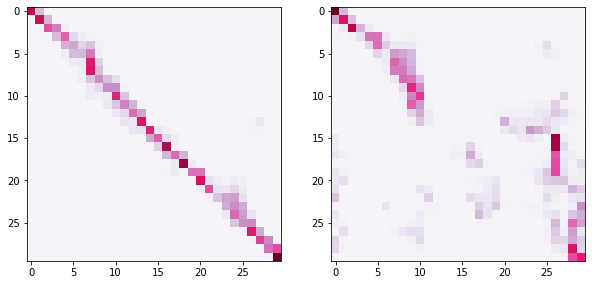

In [48]:
# fig,ax = plt.subplots()
# ax.imshow(post.mean(axis=0),cmap='PuRd')

fig,ax = plt.subplots(1,2,figsize=[10,5])
ax[0].imshow(fam_post.mean(axis=0),cmap='PuRd')
ax[1].imshow(nov_post.mean(axis=0),cmap='PuRd')

### Decoding of position in baseline trials on Day 0

In [57]:
ko_baseline_cv_post = {mouse:baseline_crossval(load_single_day(mouse,day=0)) for mouse in stx.ymaze_sess_deets.KO_sessions.keys()}
ctrl_baseline_cv_post = {mouse:baseline_crossval(load_single_day(mouse,day=0)) for mouse in stx.ymaze_sess_deets.CTRL_sessions.keys()}

({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 0}, {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel': -1, 'ravel_ind': 1})
28_09_2020 YMaze_LNovel
28_09_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
LR
block_number
sess_num_ravel
sess_num
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': 1, 'rave

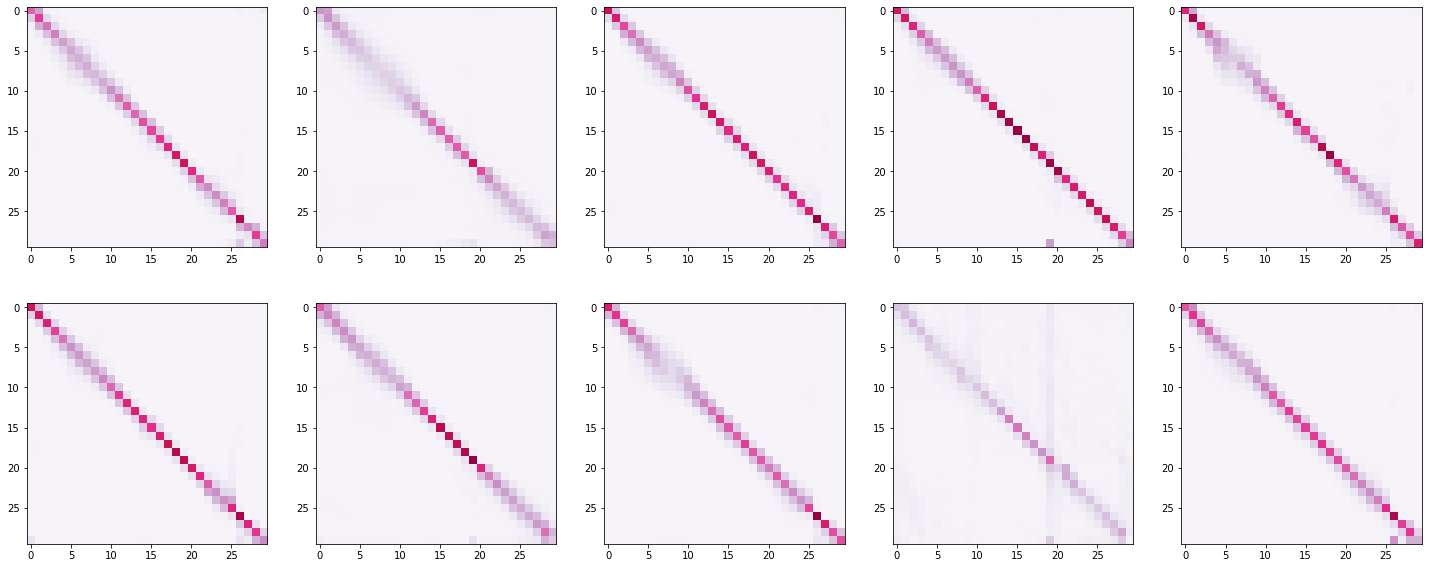

In [58]:
fig, ax = plt.subplots(2,5,figsize= [25, 10 ])

for i,(mouse,post) in enumerate(ko_baseline_cv_post.items()):
    ax[0,i].imshow(post.mean(axis=0),cmap='PuRd',vmin=0,vmax=1)
    
for i,(mouse,post) in enumerate(ctrl_baseline_cv_post.items()):
    ax[1,i].imshow(post.mean(axis=0),cmap='PuRd',vmin=0,vmax=1)

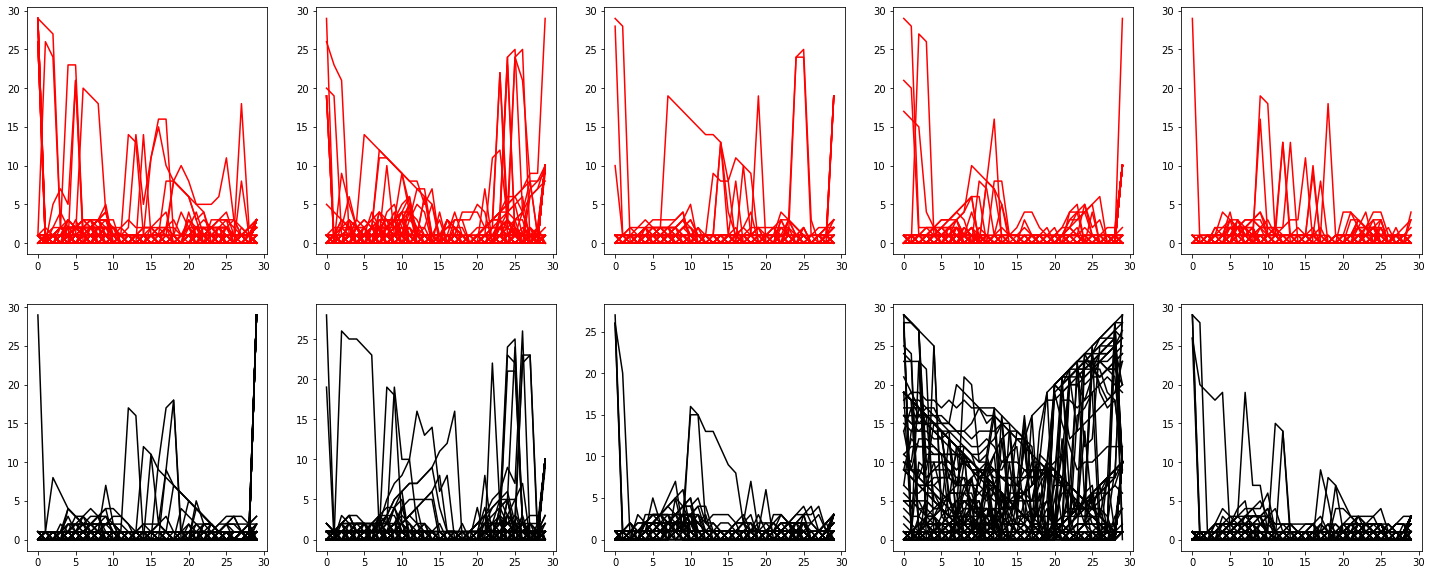

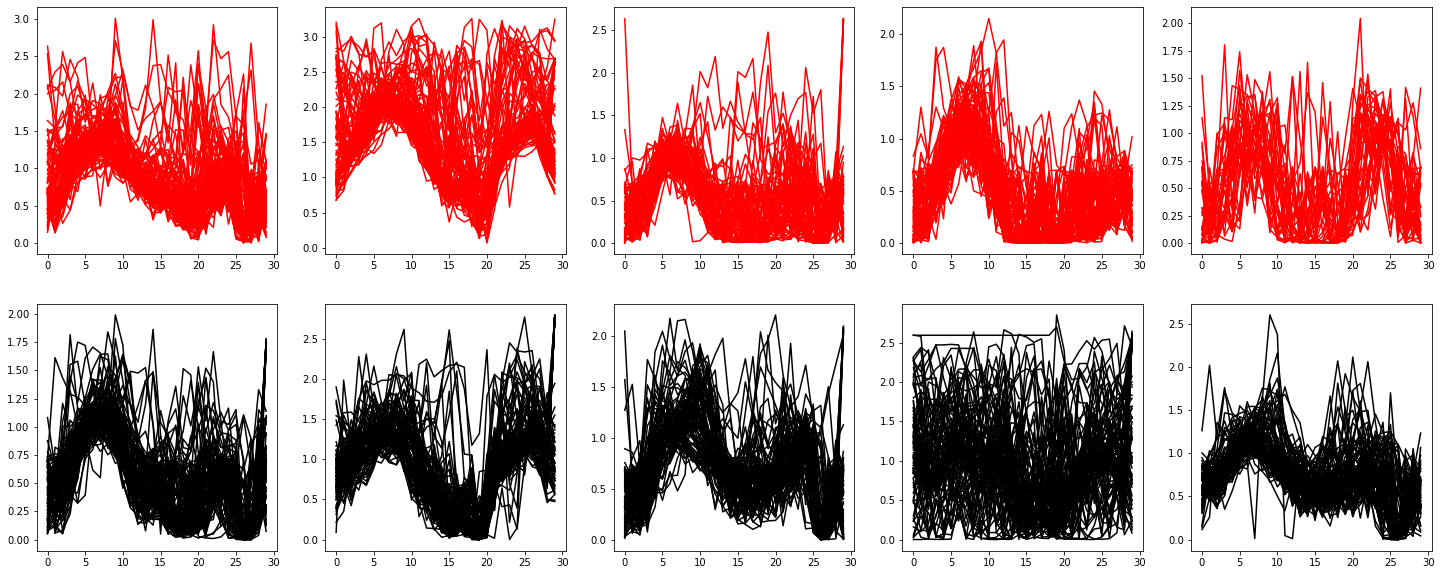

In [64]:
# decoding error as a function of position
def err_metrics(post):
    err = np.zeros([*post.shape[:2]])*np.nan
    unc = np.zeros([*post.shape[:2]])*np.nan
    true_pos = np.arange(0,post.shape[1])
    for trial in range(post.shape[0]):
        decode_pos = np.argmax(post[trial,:,:],axis=-1)
        err[trial,:] = np.abs(decode_pos-true_pos)
        unc[trial,:] = sp.stats.entropy(post[trial,:,:],axis=-1)
    return err, unc
    
    

# decoding uncertainy as a function of position
fig, ax = plt.subplots(2,5,figsize= [25, 10])
for i,(mouse,post) in enumerate(ko_baseline_cv_post.items()):
    err, unc = err_metrics(post)
    ax[0,i].plot(err.T,color = 'red')
for i,(mouse,post) in enumerate(ctrl_baseline_cv_post.items()):
    err, unc = err_metrics(post)
    ax[1,i].plot(err.T,color = 'black')
    
fig, ax = plt.subplots(2,5,figsize= [25, 10])
for i,(mouse,post) in enumerate(ko_baseline_cv_post.items()):
    err, unc = err_metrics(post)
    ax[0,i].plot(unc.T,color = 'red')
for i,(mouse,post) in enumerate(ctrl_baseline_cv_post.items()):
    err, unc = err_metrics(post)
    ax[1,i].plot(unc.T,color = 'black')
    
#     ax[0,i].imshow(post.mean(axis=0),cmap='PuRd',vmin=0,vmax=1)    
# for i,(mouse,post) in enumerate(ctrl_baseline_cv_post.items()):
#     ax[1,i].imshow(post.mean(axis=0),cmap='PuRd',vmin=0,vmax=1)

In [55]:
# sub sample cells to match N

# for n_cells in [8, 16, 32, 64, 128, 256, ]
def run_ncells_baseline_crossval(mice, day = 0):
    results = {}
    for mouse in mice:
        print('mouse', mouse)
        results[mouse]={}
        sess = load_single_day(mouse,day=day)
        for n_cells in [2**n for n in range(3,9)]:
            print('n cells', n_cells)
            post = []
            for rep in range(10):
                post.append(baseline_crossval(sess))
            post = np.concatenate(post,axis=0)
            results[mouse][n_cells]=post
    return n_cells

ko_ncells_crossval = run_ncells_baseline_crossval(stx.ymaze_sess_deets.KO_sessions.keys())
ctrl_ncells_crossval = run_ncells_baseline_crossval(stx.ymaze_sess_deets.CTRL_sessions.keys())

mouse 4467975.1
({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 0}, {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel': -1, 'ravel_ind': 1})
28_09_2020 YMaze_LNovel
28_09_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
LR
block_number
sess_num_ravel
sess_num
n cells 8


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(2,5,figsize= [25, 10 ])

for i,(mouse,post) in enumerate(ko_ncells_crossval.items()):
    ax[0,i].imshow(post[8].mean(axis=0),cmap='PuRd',vmin=0,vmax=1)
    
for i,(mouse,post) in enumerate(ctrl_ncells_crossval.items()):
    ax[1,i].imshow(post[8].mean(axis=0),cmap='PuRd',vmin=0,vmax=1)

In [54]:
def run_test_lastblock(mice, day = 0):
    results = {}
    for mouse in mice:
        
        sess = load_single_day(mouse, day = day)
        fam_post, nov_post = train_baseline_test_lastblock(sess, n_cells = -1, poisson=True)
        results[mouse]={'fam':fam_post, 'nov':nov_post}
    return results

ko_test_lastblock = run_test_lastblock(stx.ymaze_sess_deets.KO_sessions.keys())
ctrl_test_lastblock = run_test_lastblock(stx.ymaze_sess_deets.CTRL_sessions.keys())

({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 0}, {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel': -1, 'ravel_ind': 1})
28_09_2020 YMaze_LNovel
28_09_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
LR
block_number
sess_num_ravel
sess_num
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': 1, 'rave

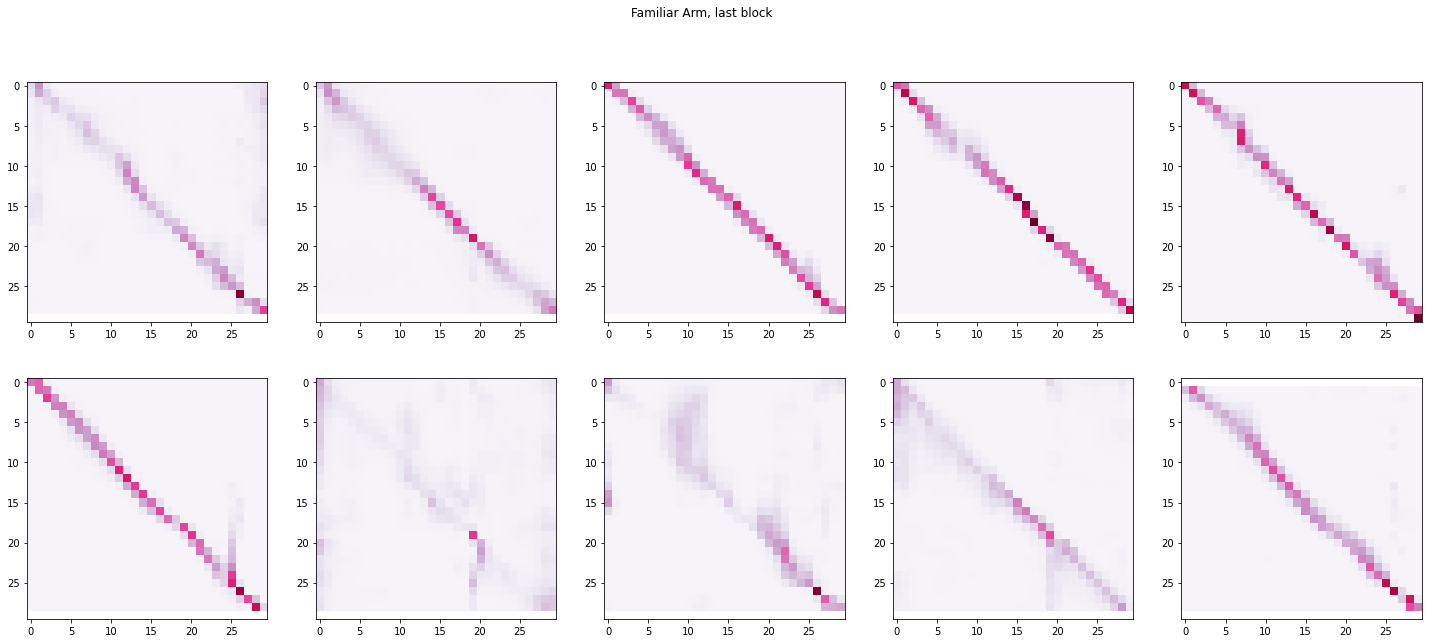

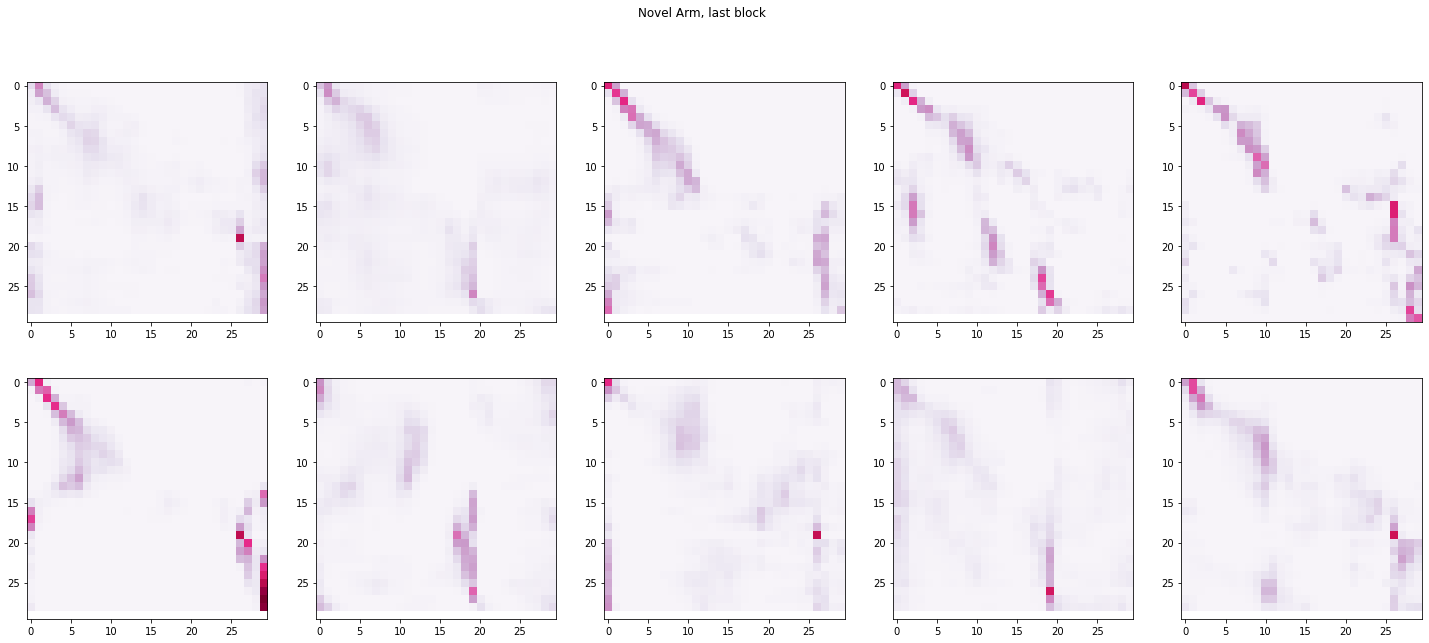

In [57]:
fig, ax = plt.subplots(2,5,figsize= [25, 10 ])
fig.suptitle('Familiar Arm, last block')
for i,(mouse,post) in enumerate(ko_test_lastblock.items()):
    ax[0,i].imshow(post['fam'].mean(axis=0),cmap='PuRd',vmin=0,vmax=1)
    
for i,(mouse,post) in enumerate(ctrl_test_lastblock.items()):
    ax[1,i].imshow(post['fam'].mean(axis=0),cmap='PuRd',vmin=0,vmax=1)
    
    
fig, ax = plt.subplots(2,5,figsize= [25, 10 ])
fig.suptitle('Novel Arm, last block')
for i,(mouse,post) in enumerate(ko_test_lastblock.items()):
    ax[0,i].imshow(post['nov'].mean(axis=0),cmap='PuRd',vmin=0,vmax=1)
    
for i,(mouse,post) in enumerate(ctrl_test_lastblock.items()):
    ax[1,i].imshow(post['nov'].mean(axis=0),cmap='PuRd',vmin=0,vmax=1)